<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/CMAPSS_Rul_Prediction_HPC_and_Fan_Degradation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMAPSS RUL Prediction (HPC and Fan Degradation)

This project aims to estimate remaining useful life (RUL) for CMAPSS Nasa Jet Engine data. The way I'm doing here is to check if a specific engine will fail within next 30 cycles.

This notebooks uses a dataset with engines that runned until failure, containing HPC and Fan degradation.

https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ‘Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation’, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.



In [1]:
import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

In [3]:
jet_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/train_FD004.txt", sep=" ", header=None) #HPC Degradation
test_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/test_FD004.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

In [4]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [5]:
test_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326


In [6]:
#evaluate RUL for each cycle
# to do this I need to check max cycle for each engine and subtract max cycle - cycle
#add RUL column to test data
def RUL_calculator(df):

    df_max_cycles = df.groupby(['id'])[["id" ,"cycle"]].max()
    df_max_cycles.set_index('id', inplace=True)

    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data)
test_data = RUL_calculator(test_data)

In [7]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [8]:
test_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,229
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,228
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,227
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,226
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,225


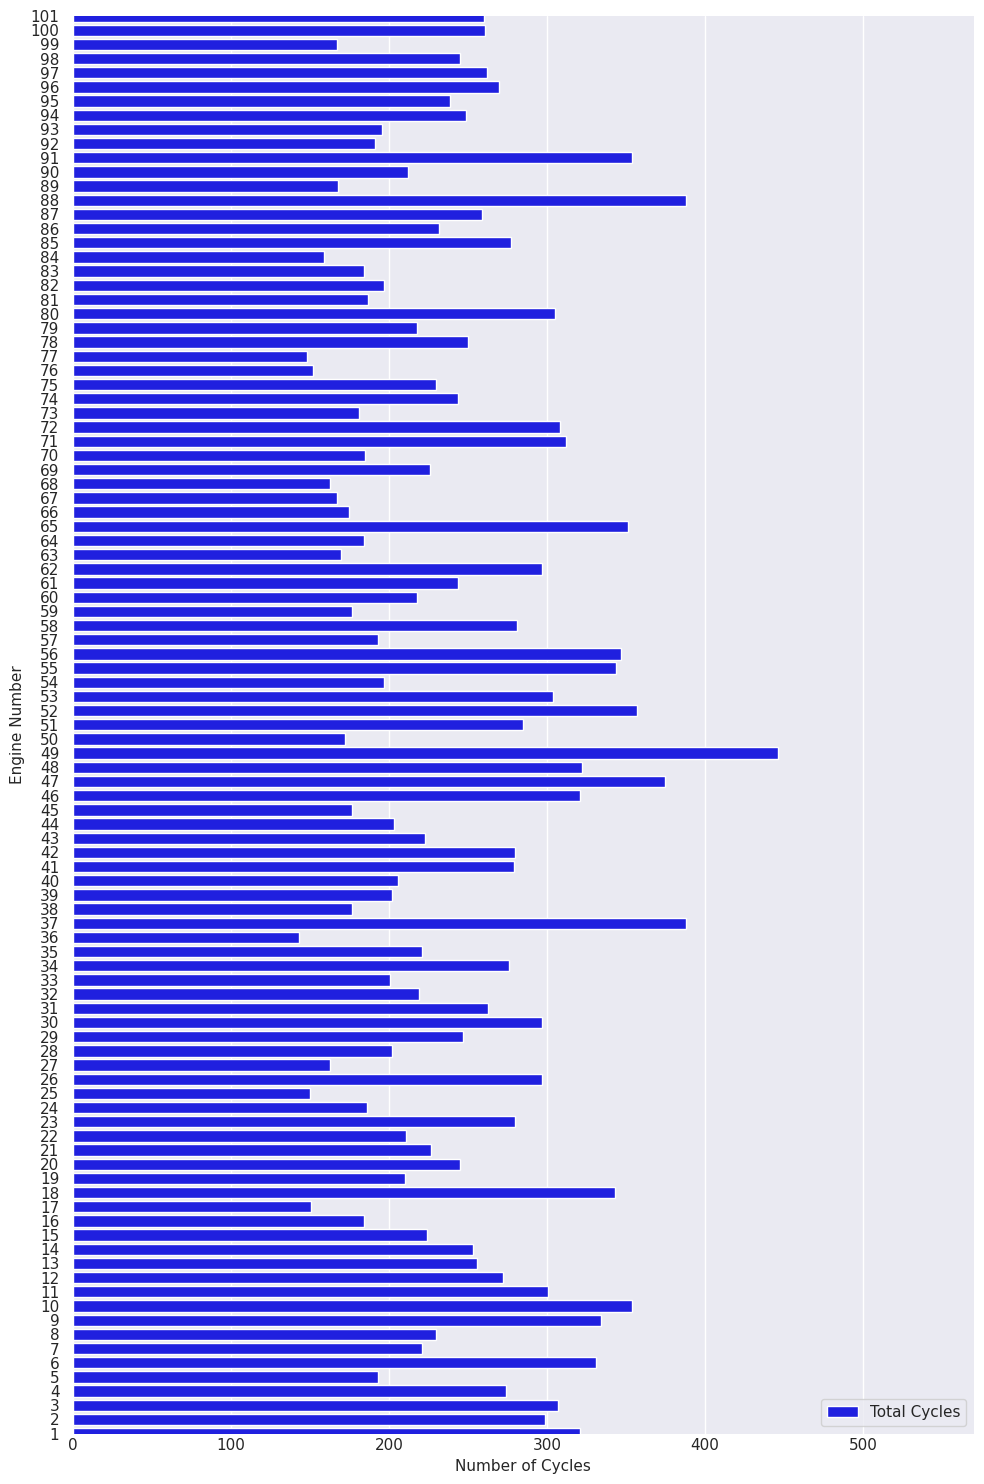

In [9]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="engine id",xlabel="Lifetime for each engine")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

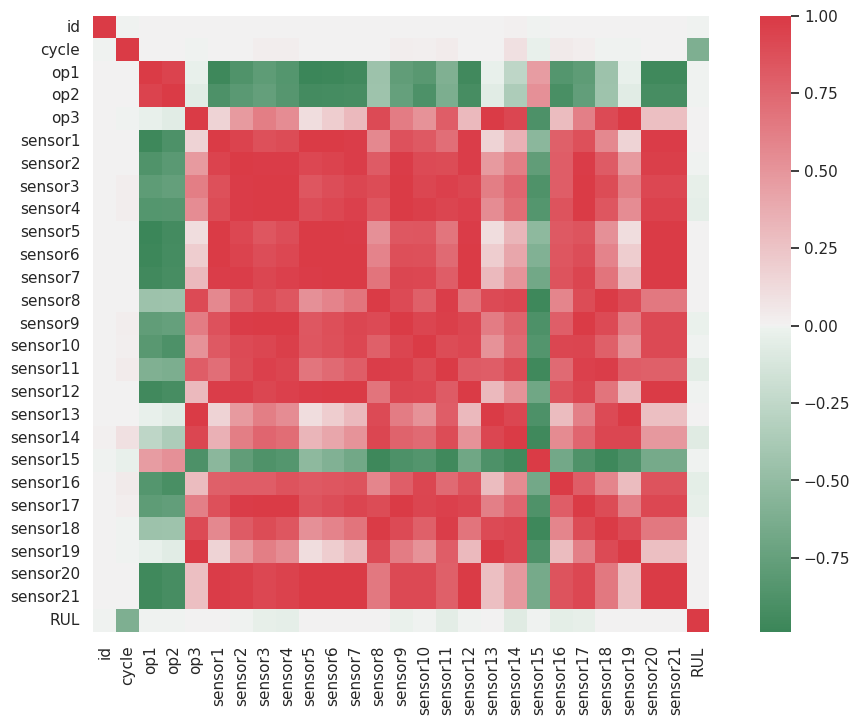

In [10]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

Based on data above it seems that op1, op2, op3, sensor1, sensor 5, sensor 10, sensor18 and sensor19 do not impact RUL

note: this data FD001 uses only 1 setting of operational conditions, for FD004 probably it will have impact

In [11]:
#drop non relevant sensor data

train_data = jet_data.drop(["sensor1", "sensor5", "sensor6", "sensor18", "sensor19", "sensor13", "sensor12"], axis=1)

In [12]:
test_data = test_data.drop(["sensor1", "sensor5", "sensor6", "sensor18", "sensor19", "sensor13", "sensor12"], axis=1)

In [13]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=train_data.drop(['id', 'RUL'], axis=1).columns)

In [14]:
test_scaled_features = scaler.fit_transform(test_data.drop(['id', 'RUL'], axis=1))
test_scaled_features = pd.DataFrame(test_scaled_features, columns=test_data.drop(['id', 'RUL'], axis=1).columns)

In [15]:
scaled_features['id'] = train_data['id']
scaled_features['RUL'] = train_data['RUL']

test_scaled_features['id'] = test_data['id']
test_scaled_features['RUL'] = test_data['RUL']

In [16]:
prepared_data = scaled_features.copy()
prepared_test_data = test_scaled_features.copy()

In [17]:
prepared_data.head()

,cycle,op1,op2,op3,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor10,sensor11,sensor14,sensor15,sensor16,sensor17,sensor20,sensor21,id,RUL
0,0.000000,0.999926,0.997625,1.0,0.130347,0.272082,0.212586,0.002738,0.626983,0.269578,0.205128,0.458604,0.550773,0.400540,0.0,0.288660,0.015473,0.015881,1,320
1,0.001845,0.476147,0.831591,1.0,0.647971,0.634407,0.511781,0.450787,0.862888,0.601411,0.358974,0.641234,0.481761,0.351346,0.0,0.608247,0.477968,0.481487,1,319
2,0.003690,0.999900,0.998694,1.0,0.123646,0.271245,0.222481,0.004625,0.627110,0.265759,0.205128,0.456169,0.531031,0.423787,0.0,0.278351,0.010764,0.018932,1,318
3,0.005535,0.999810,0.997625,1.0,0.121351,0.266168,0.224835,0.004164,0.627026,0.270428,0.230769,0.457792,0.553707,0.401716,0.0,0.268041,0.012782,0.018724,1,317
4,0.007380,0.595275,0.737173,0.0,0.005691,0.033916,0.022025,0.088924,0.001055,0.008603,0.000000,0.035714,0.048140,0.920536,0.0,0.030928,0.130172,0.145560,1,316


In [18]:
prepared_test_data.head()

,cycle,op1,op2,op3,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor10,sensor11,sensor14,sensor15,sensor16,sensor17,sensor20,sensor21,id,RUL
0,0.000000,0.476271,0.831354,1.0,0.656561,0.654027,0.501557,0.453603,0.863015,0.627579,0.358974,0.639344,0.574006,0.362211,0.0,0.631579,0.478320,0.483780,1,229
1,0.002062,0.595087,0.736342,0.0,0.007372,0.041486,0.016265,0.088661,0.000612,0.011285,0.000000,0.006557,0.039366,0.945325,0.0,0.042105,0.141260,0.137380,1,228
2,0.004124,0.999810,1.000000,1.0,0.127258,0.270191,0.200168,0.002955,0.627093,0.278278,0.205128,0.450000,0.637839,0.423747,0.0,0.273684,0.006775,0.016466,1,227
3,0.006186,0.999893,0.997862,1.0,0.126889,0.269020,0.203579,0.002701,0.627008,0.274449,0.205128,0.467213,0.660202,0.410736,0.0,0.273684,0.012534,0.005168,1,226
4,0.008247,0.833363,0.997625,1.0,0.181349,0.305358,0.229632,0.131329,0.649853,0.300717,0.230769,0.433607,0.599510,0.390686,0.0,0.326316,0.157859,0.157613,1,225


In [19]:
cycle=30
prepared_data['label'] = prepared_data['RUL'].apply(lambda x: 1 if x <= cycle else 0) #label 0 if engine has more than 30 cycles of RUL
prepared_test_data['label'] = prepared_test_data['RUL'].apply(lambda x: 1 if x <= cycle else 0) #label 0 if engine has more than 30 cycles of RUL

In [20]:
y_train = prepared_data['label']
X_train = prepared_data.drop(['RUL', 'id', 'label'], axis=1)

y_test = prepared_test_data['label']
X_test = prepared_test_data.drop(['RUL', 'id', 'label'], axis=1)


#y = prepared_data['label']
#X = prepared_data.drop(['RUL', 'id', 'label'], axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)


print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (61249, 18)
X_test shape :  (41214, 18)
y_train shape :  (61249,)
y_test shape :  (41214,)


##RandomForest

In [21]:
classifier = RandomForestClassifier(random_state=90, oob_score = False)

# Define the parameter Grid
params = {
 'max_depth': [18, 20, 22],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [22, 25],
 'min_samples_leaf': [12, 10, 8],
 'n_estimators': [20, 30, 40]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

0.847444658268935

In [22]:
grid_search.best_params_

{'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 22,
 'n_estimators': 40}

In [23]:
pred = grid_search.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.8349347309166788
Roc Auc Score:  0.6030360798316441
Precision Score:  0.6447084233261339
Recall Score:  0.23544104114631262
f1 score:  0.34492055849783343


<Figure size 1500x800 with 0 Axes>

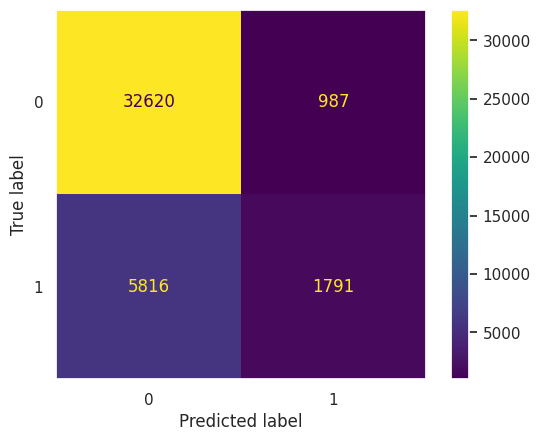

In [24]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

##Logistic Regression

In [25]:
lr_classifier = LogisticRegression()

# Define the parameter Grid
params = {
 'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['l2'],
 'C': [1.2, 1.5, 1.8]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=lr_classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.7278739163121142

In [26]:
pred = grid_search.predict(X_test)

print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.8328723249381278
Roc Auc Score:  0.622061043679557
Precision Score:  0.5981972138759901
Recall Score:  0.28789273037991325
f1 score:  0.3887113951011715


<Figure size 1500x800 with 0 Axes>

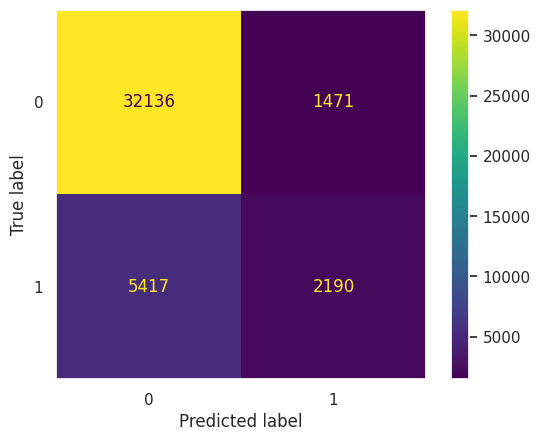

In [27]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

##LGBMClassifier

In [28]:
import lightgbm as lgb
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,n_estimators=5000,num_leaves=100,objective='binary', metrics='auc',random_state=50,n_jobs=-1)
lgb_clss.fit(X_train, y_train)
lgb_clss.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 7719, number of negative: 53530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3490
[LightGBM] [Info] Number of data points in the train set: 61249, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126027 -> initscore=-1.936557
[LightGBM] [Info] Start training from score -1.936557


0.836196438103557

In [29]:
preds2 = lgb_clss.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2,average='binary'))

Acc Score:  0.836196438103557
Roc Auc Score:  0.612352709794848
Precision Score:  0.6397779229261921
Recall Score:  0.2575259629288813
f1 score:  0.367232167963258


<Figure size 1500x800 with 0 Axes>

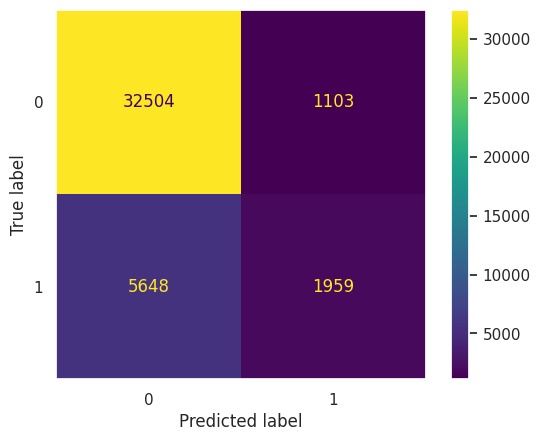

In [30]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, preds2, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

##RandomizedSearchCV

In [31]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1),
         'subsample': np.arange( 0.7, 1, 0.05),
         'gamma': np.arange(0.5, 1, 0.1),
         'colsample_bytree': np.arange( 0.1, 1, 0.05),
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                   param_distributions={'colsample_bytree': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'gamma': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': array([0.01 , 0.035, 0.06 , 0.085]),
                                        'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'scale_pos_weight': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190]),
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])})

In [32]:
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))
print('Acc Score: ',accuracy_score(y_test, y_pred))
print('Roc Auc Score: ',roc_auc_score(y_test, y_pred))
print('Precision Score: ',precision_score(y_test, y_pred))
print('Recall Score: ',recall_score(y_test, y_pred))
print('f1 score: ',f1_score(y_test, y_pred,average='binary'))

Best Parameter: 
 {'subsample': 0.75, 'scale_pos_weight': 80, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.085, 'gamma': 0.7999999999999999, 'colsample_bytree': 0.6000000000000002}
XGBClassifier Acc Score:  0.8327995341388849
Acc Score:  0.8327995341388849
Roc Auc Score:  0.6248132195787348
Precision Score:  0.5948595654478007
Recall Score:  0.2951229131063494
f1 score:  0.39451717775239437


<Figure size 1500x800 with 0 Axes>

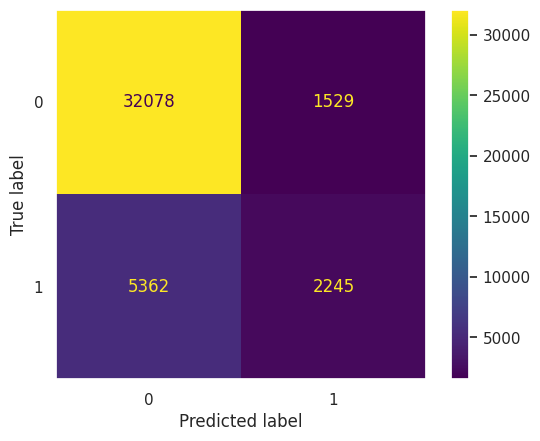

In [33]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()